In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
from environments.simulator_env_1 import SimulatorEnv1, LogisticModelFeature

INTERCEPT = 10
N = 10000

BASE_PRICE = LogisticModelFeature(
    name="base_price",
    model_coefficient=-1 / 25,
    space="simulator1_price",
    mean_base_price=100,
)
APW = LogisticModelFeature(
    name="apw",
    model_coefficient=-1 / 10,
    space="negative_binomial",
    mean=14,
)
OCCOUPANCY = LogisticModelFeature(
    name="occupancy",
    model_coefficient=1 / 10,
    space="beta_distribution",
    alpha=1.5,
    beta=5,
)

NIGHT = LogisticModelFeature(
    name="night",
    model_coefficient=0.1,
    space="random",
    low=1,
    high=8,
)

STARS = LogisticModelFeature(
    name="hotel_level",
    model_coefficient=-0.2,
    space="random",
    low=0,
    high=5,
)

PROMOTION = LogisticModelFeature(
    name="promotion",
    model_coefficient=-1 / 10,
    space="negative_binomial",
    mean=4,
)

CUSTOMER_TYPE = LogisticModelFeature(
    name="customer_type",
    model_coefficient=0.1,
    space="random",
    low=0,
    high=1,
)

FEATURES = {
    "base_price": BASE_PRICE,
    "apw": APW,
    "occupancy": OCCOUPANCY,
    "night": NIGHT,
    "hotel_level": STARS,
    "promotion": PROMOTION,
    "customer_type": CUSTOMER_TYPE,
}
env = SimulatorEnv1(
    discrete_action_space=True,
    intercept=INTERCEPT,
    features=FEATURES,
    n_reps=N,
    first_arm=0.1,
    last_arm=0.9,
    
)

In [6]:
print(env.observation_space)
data = env.get_obs_dataset(100)
data.head()

Dict('apw': <environments.spaces_gym.NegBinomialSpace object at 0x12cc00e20>, 'base_price': <environments.spaces_gym.Simulator1_Price_Space object at 0x12ce76710>, 'customer_type': <environments.spaces_gym.RandomSpace object at 0x12cc00f40>, 'hotel_level': <environments.spaces_gym.RandomSpace object at 0x12cc03130>, 'night': <environments.spaces_gym.RandomSpace object at 0x12cc026e0>, 'occupancy': <environments.spaces_gym.BetaDistributionSpace object at 0x12cc00940>, 'promotion': <environments.spaces_gym.NegBinomialSpace object at 0x12cc01b70>)


,apw,base_price,customer_type,hotel_level,night,occupancy,promotion
0,6,186.449962,1,3,2,2,3
1,72,199.390025,1,2,8,5,1
2,26,159.450858,0,2,6,2,0
3,0,175.077632,0,3,6,5,3
4,11,172.820999,1,5,1,2,3


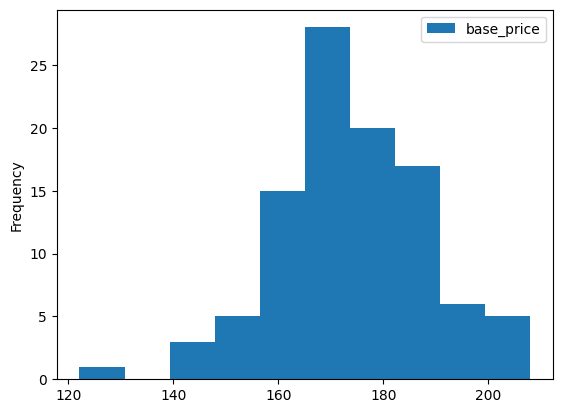

In [20]:
data['base_price'].plot.hist()
plt.legend()
plt.show()

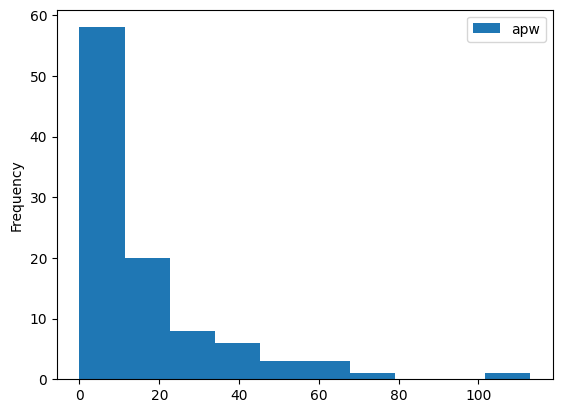

In [19]:
data['apw'].plot.hist()
plt.legend()
plt.show()

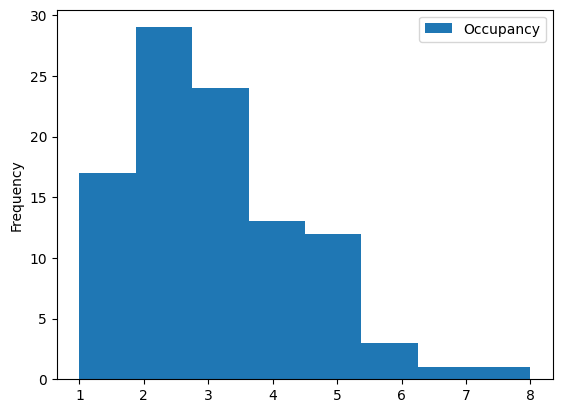

In [15]:
data['occupancy'].plot.hist(bins=8)  # Adjust the number of bins as needed


plt.legend(['Occupancy'])
plt.show()

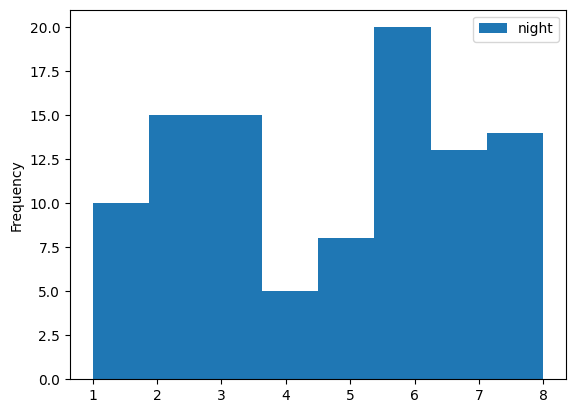

In [17]:
data['night'].plot.hist(bins = 8)
plt.legend()
plt.show()

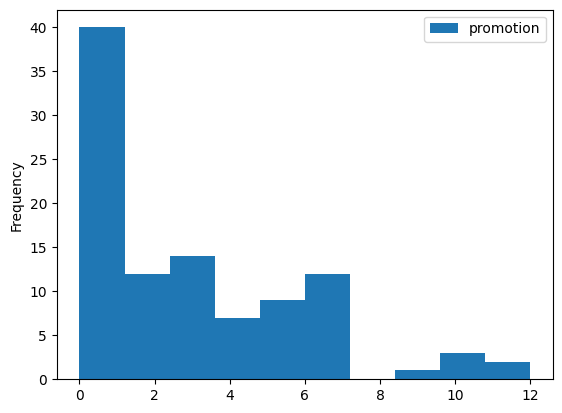

In [18]:
data["promotion"].plot.hist(),
plt.legend()
plt.show()

In [ ]:
data['hotel_level'].plot.hist(),

Text(0.5, 0, ' $p$ [\\$]')

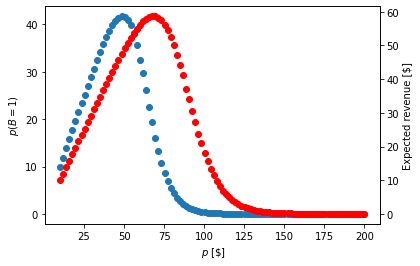

In [16]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

d = []
b = []
prices = np.linspace(10, 200, 100)
apw = 7
for price in prices:
    d.append(
        price
        *
        env.demand_function4(
            action=1, base_price=price, apw=apw, occupancy=2, night=2, hotel_level=4, customer_type=0, promotion=0.9
        )
    )
    b.append(
        price
        * env.demand_function4(
            action=1, base_price=price, apw=apw, occupancy=2, night=2, hotel_level=4, customer_type =1, promotion=0.9
        )
    )

ax1.scatter(prices, d)
ax1.set_ylabel("$p(B=1)$")
ax2.scatter(prices, b, color="red")
ax2.set_ylabel("Expected revenue [$]")
ax1.set_xlabel(" $p$ [\$]")

In [17]:
max(d), max(b)

(41.73984603393715, 58.645832296458636)

In [1]:
from train.train import train_model_6
from train.train_utils import *
arms_range=[0.1, 0.5] 
n_arm = 40
models_choice = ["Random", "UCB1", "EG", "Fixed"]
ini_data, env  = get_data_6(arms_range, n_arm)



In [2]:
MODELS = {
    "Random": LearningPolicy.Random(),
    "UCB1": LearningPolicy.UCB1(alpha=1.2),
    "EG": LearningPolicy.EpsilonGreedy(epsilon=0.2),
    "TS": LearningPolicy.ThompsonSampling(),
}

In [3]:
results = {}
for model in models_choice:
    if model != 'Fixed':
        agent, env = train_profit_reward_5(
                        ini_data.copy(),
                        env,
                        60,
                        'retrain_every_data',
                        arms_range,
                        n_arm,
                        MODELS[model],
                    )
        df = agent.data.copy()
        actions = df['action'].unique()
        results[model] = agent.data
    df = results['Random']
    results['Fixed'] = train_and_eva_fixed_5( env, df )

In [4]:
import matplotlib.pyplot as plt
import numpy as np

def create_cumulative_rewards_static(dfs, ind):
    # Initialize the figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot each model's data
    for model_name, df in dfs.items():
        if ind == "converted":
            cumulative_sum = df["converted"].cumsum()
            n_observations = np.arange(1, len(df) + 1)
            y_value = cumulative_sum / n_observations
        else:
            ttv = df["reward"].cumsum()
            n_observations = np.arange(1, len(df) + 1)
            y_value = ttv / n_observations
        ax.plot(n_observations, y_value, label=model_name)

    # Add lines for promotion and demand change milestones
    promotion_marks = [6000, 12000, 18000]
    demand_changes = [8000, 14000, 20000, 76000]

    for x in promotion_marks:
        ax.axvline(x=x, color='green', linestyle='--', label='Promotion Change' if x == promotion_marks[0] else "")
    
    for x in demand_changes:
        ax.axvline(x=x, color='blue', linestyle=':', label='Demand Change' if x == demand_changes[0] else "")
    
    # Customize the plot
    ax.set_xlabel('Number of Observations')
    ax.set_ylabel(ind.capitalize())
    ax.set_title(f'Cumulative {ind.capitalize()} Over Observations')
    ax.legend()

    # Show the figure
    plt.tight_layout()
    plt.show()

# Example usage
# Assuming dfs is your dictionary of dataframes with model names as keys
# and ind is either "converted" or another metric like "reward"



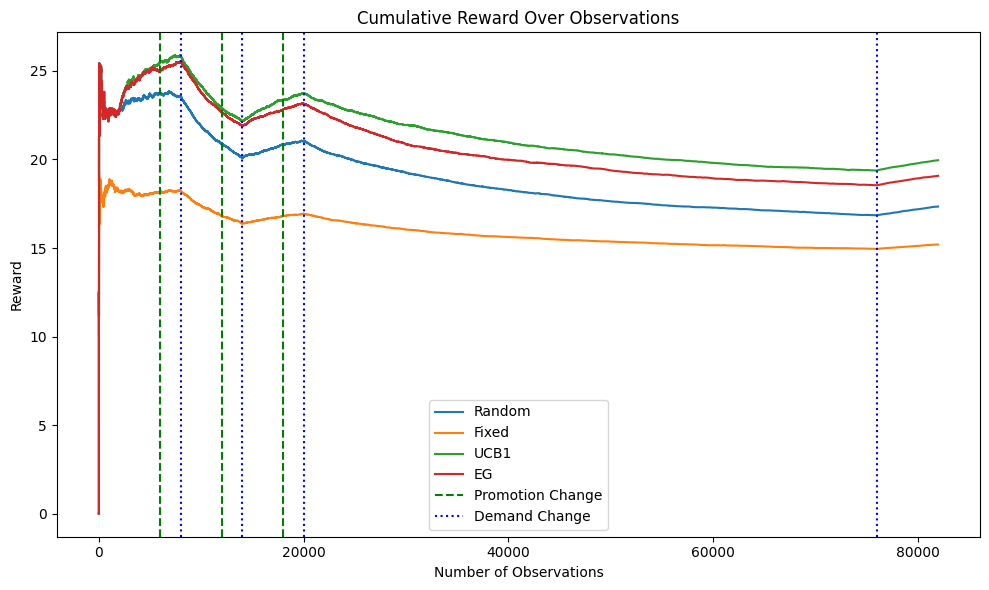

In [5]:
create_cumulative_rewards_static(results, "reward")